# 0.0. Introducao

## 0.1. Bibliotecas

In [1]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb
import inflection
import math
import warnings
import random
import pickle

from datetime              import datetime
from datetime              import timedelta
from tabulate              import tabulate
from scipy                 import stats
from boruta                import BorutaPy

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor, RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

## 0.2. Funções Auxiliares

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k - 1) * (r - 1) / (n-1) )
    
    kcorr = k - ( k - 1 ) ** 2 / ( n - 1 )
    rcorr = r - ( r - 1 ) ** 2 / ( n - 1 )
    
    return np.sqrt( (chi2corr / n) / (min( kcorr-1, rcorr-1 ) ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error(y ,yhat)
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {' Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0] )

def cross_validation( x_training, kfold, model_name, model, verbose= False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\n Kfolde Number {}'.format( k ) )
        validation_start_date = x_training['date'].max() - timedelta( days = k * 6 * 7 )  
        validation_end_date = x_training['date'].max() - timedelta( days = ( k - 1 ) * 6 * 7 )

        # filtro do datset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ ( x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date )]

        # treino e validacao dos dados
        xtraining = training.drop( ['date', 'sales'], axis = 1 )
        ytraining = training['sales']

        xvalidation = validation.drop( ['date', 'sales'], axis = 1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # predicao
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    return pd.DataFrame( {'Model Name': model_name,
                              'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                              'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                              'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ) .astype( str ) }, index = [0] )

## 0.3. Carregar os Dados

In [3]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory= False )
df_store_raw = pd.read_csv( 'store.csv', low_memory= False )


# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

# 1.0. Descrição dos Dados

In [4]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [5]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

new_cols = list( map( snakecase, old_cols ))

df1.columns = new_cols

## 1.2. Dimensões dos Dados

In [6]:
print( 'Numero de Linhas:  {}'.format( df1.shape[0] ) )
print( 'Numero de Colunas: {}'.format( df1.shape[1] ) )

Numero de Linhas:  1017209
Numero de Colunas: 18


## 1.3. Tipos de Dados

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [9]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 20000.0 if math.isnan( x ) else x )

# competition_open_since_month 
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1 )

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1 )
                      
# promo2_since_week            
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1 )

# promo2_since_year            
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1 )

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

## 1.6. Mundanca de Tipos

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Estatítisca Descritiva

In [11]:
num_atributos = df1.select_dtypes( include = ['int64', 'float64'] )
cat_atributos = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Atributos Numéricos

In [12]:
# tendencia central - mean, median
tc1 = pd.DataFrame( num_atributos.apply( np.mean ) ).T
tc2 = pd.DataFrame( num_atributos.apply( np.median ) ).T

# dispersao - max, min, std, range, skew, kurtosis
d1 = pd.DataFrame( num_atributos.apply( max ) ).T
d2 = pd.DataFrame( num_atributos.apply( min ) ).T
d3 = pd.DataFrame( num_atributos.apply( np.std ) ).T
d4 = pd.DataFrame( num_atributos.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributos.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributos.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d1, d4, tc1, tc2, d3, d5, d6] ).T.reset_index()
m.columns = ['Atributos', 'Min', 'Max', 'Range', 'Media', 'Mediana', 'STD', 'Skew', 'Kurtosis']
m

,Atributos,Min,Max,Range,Media,Mediana,STD,Skew,Kurtosis
0,store,1.000,1115.000,1114.000,558.430,558.000,321.908,-0.001,-1.201
1,day_of_week,1.000,7.000,6.000,3.998,4.000,1.997,0.002,-1.247
2,sales,0.000,41551.000,41551.000,5773.819,5744.000,3849.924,0.641,1.778
3,customers,0.000,7388.000,7388.000,633.146,609.000,464.412,1.599,7.092
4,open,0.000,1.000,1.000,0.830,1.000,0.376,-1.758,1.091
5,promo,0.000,1.000,1.000,0.382,0.000,0.486,0.488,-1.762
6,school_holiday,0.000,1.000,1.000,0.179,0.000,0.383,1.678,0.815
7,competition_distance,20.000,75860.000,75840.000,5467.928,2330.000,7740.897,2.895,12.724
8,competition_open_since_month,1.000,12.000,11.000,6.787,7.000,3.311,-0.042,-1.233
9,competition_open_since_year,1900.000,2015.000,115.000,2010.325,2012.000,5.516,-7.236,124.071


### 1.7.2 Atributos Categoricos

In [13]:
cat_atributos.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

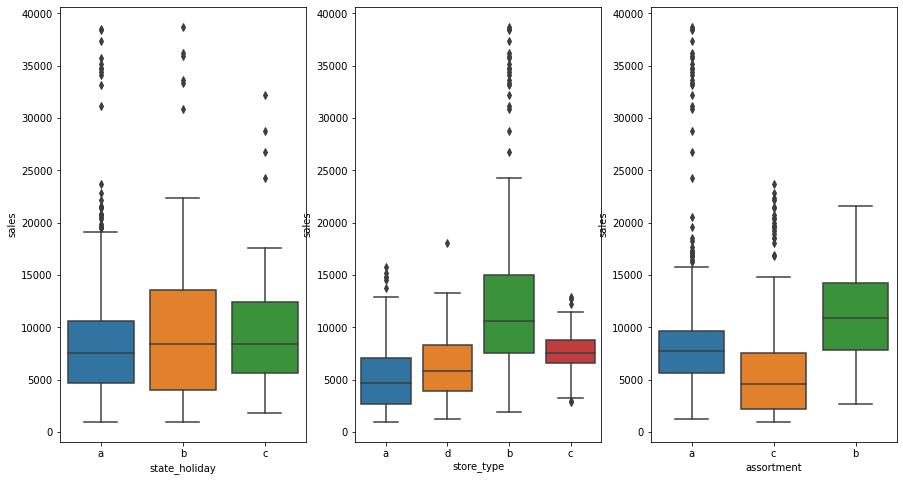

In [14]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.figure( figsize=( 15,8 ) )

plt.subplot( 1, 3, 1 )
sns.boxplot( x= 'state_holiday', y='sales' , data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x= 'store_type', y='sales', data= aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x= 'assortment', y = 'sales', data= aux1 );

# 2.0. Feature Engeneering

In [15]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

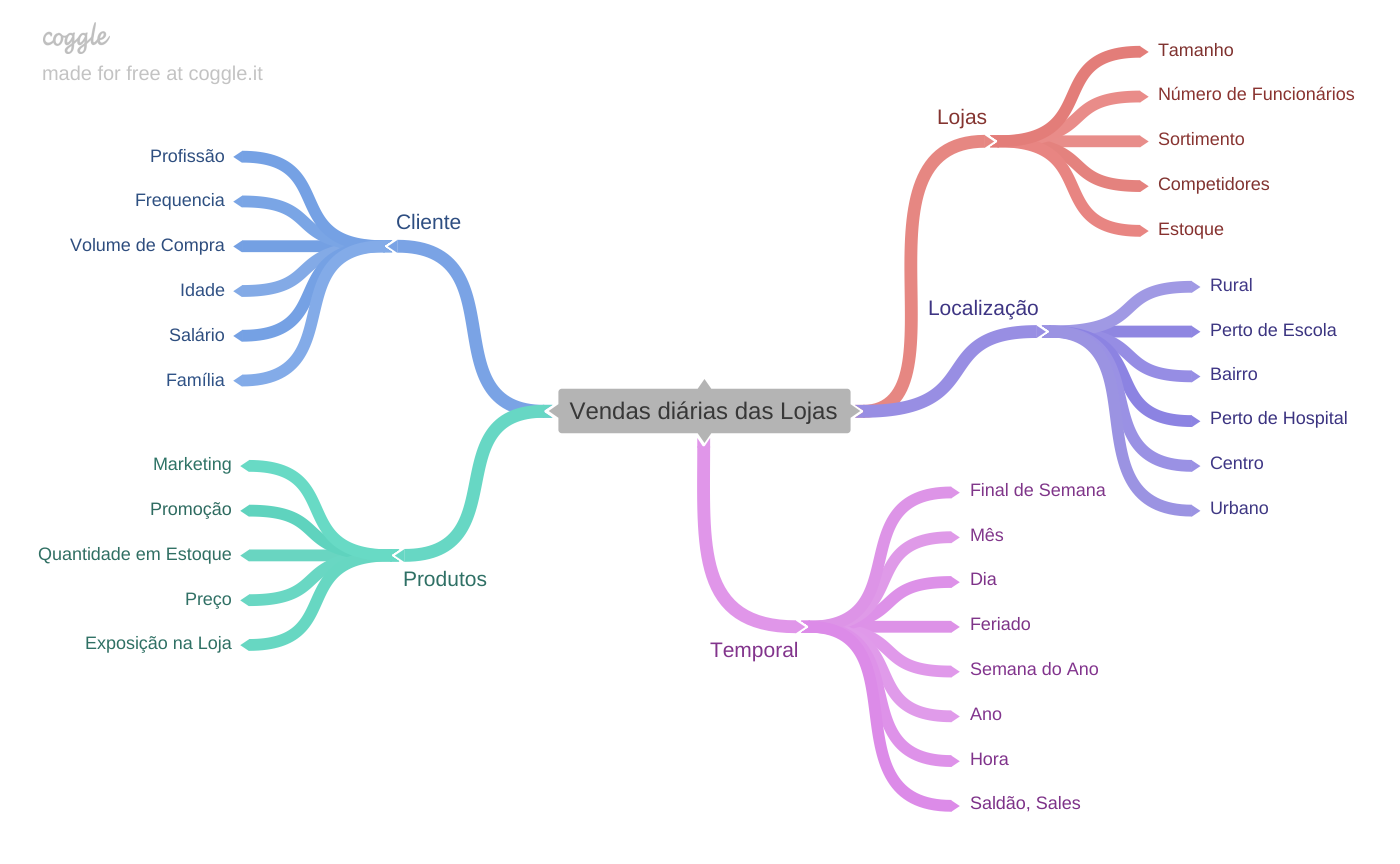

In [16]:
Image( 'Vendas_diarias_das_Lojas.coogle.png' )

## 2.2. Cricao das Hipoteses

### 2.2.1 Hipoteses Loja

- Lojas com número maior de funcionários deveriam vender mais.
- Lojas com maior capaciadade de estoque deveriam vender mais.
- Lojas com maior porte deveriam vender mais.
- Lojas com maior sortimento de produtos deveriam vender mais.
- Lojas com competidores mais próximos deveriam vender menos.
- Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipoteses Produto

- Lojas que investem mais em marketing deveriam vender mais.
- Lojas com maior exposição de produtos deveriam vender mais.
- Lojas com produtos com preço menor deveriam vender mais.
- Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
- Lojas com promoções ativas por mais tempo deveriam vender mais.
- Lojas com mais dias de promoção deveriam vender mais.
- Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

- Lojas abertas durante o feriado de Natal deveriam vender mais.
- Lojas deveriam vender mais ao longo dos anos.
- Lojas deveriam vender mais durante o segundo semestre do ano.
- Lojas deveriam vender mais depois do dia 10 de cada mês.
- Lojas deveriam vender menos durante os finais de semana.
- Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista final de Hipoteses

**1.** Lojas com maior sortimento de produtos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais durante o segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos durante os finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engeneering

In [17]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime( year = x['competition_open_since_year'] , month = x['competition_open_since_month'], day = 1  ), axis = 1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( 'int64' ) 

# promo since 
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days = 7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else
                                                       'extra' if x == 'b' else
                                                       'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else
                                                             'easter_holiday' if x == 'b' else
                                                             'christmas' if x == 'c' else
                                                             'regular_day' )

# 3.0. Filtragem de Variáveis

In [18]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [19]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Filtragem das Colunas

In [20]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

# 4.0. Analise Exploratoria dos Dados

In [21]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Variavel Resposta

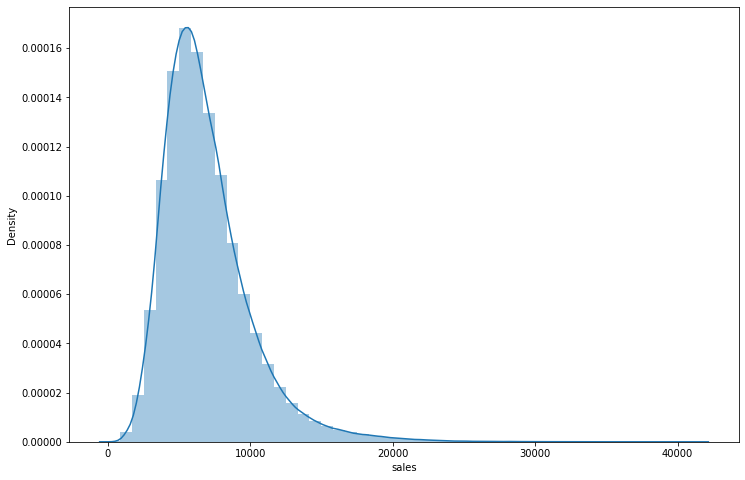

In [22]:
plt.figure( figsize = ( 12,8 ) ) 
sns.distplot( df4['sales']);

### 4.1.2. Variavel Numerica

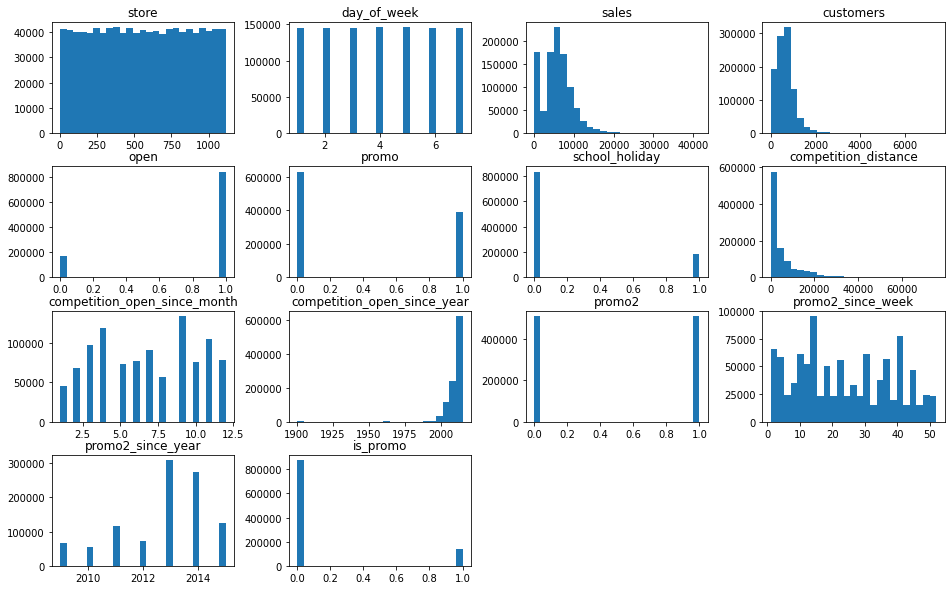

In [23]:
num_atributos.hist(grid = False, figsize = ( 16,10 ), bins = 25 );

Com esses plots podemos tirar algumas conclusões:
- A variável resposta é bem próxima de uma distribuição normal
- A maior frequencia de vendas se concentra entre 400 e 800
- A maior parte dos competidores se concentram próximos das lojas da Rossmann
- A maior parte das promoções são feitas nas primeiras 15 semanas do ano
- A empresa fez muitas promoções em 2013 e 2014, em 2015 as promoções voltaram para patar próximo aos de 2011

### 4.1.3. Variavel Categorica

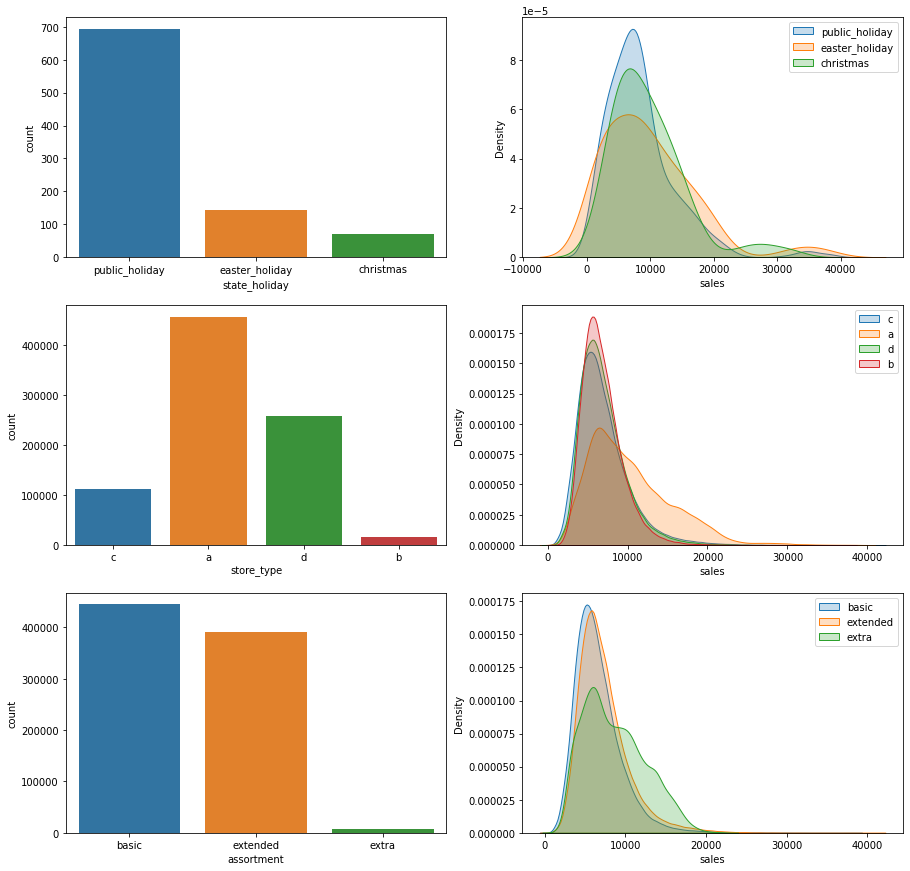

In [24]:
# state_holiday
plt.figure( figsize = (15,15) )
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], shade = True )
plt.legend( labels = ['public_holiday', 'easter_holiday', 'christmas'] );

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], shade = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], shade = True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], shade = True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], shade = True )
plt.legend( labels = ['c', 'a', 'd', 'b' ] );

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], shade = True )
plt.legend( labels = ['basic', 'extended', 'extra'] );

## 4.2. Analise Bivariada

### 4.2.1. H1) Lojas com maior sortimento de produtos deveriam vender mais.
 **Falsa**. Lojas com maior sortimento vendem MENOS.

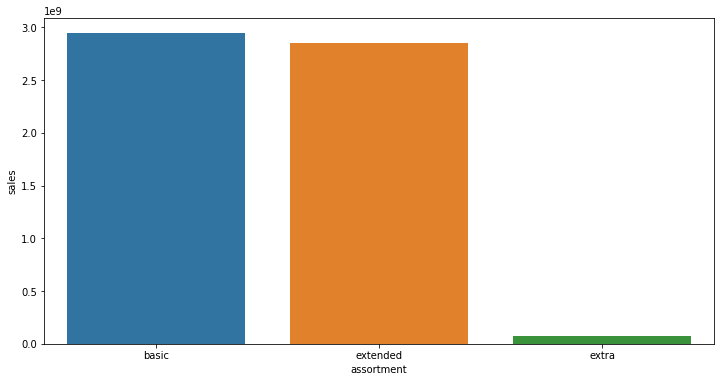

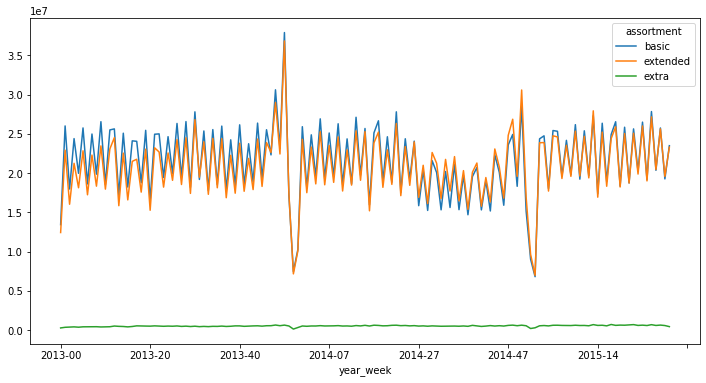

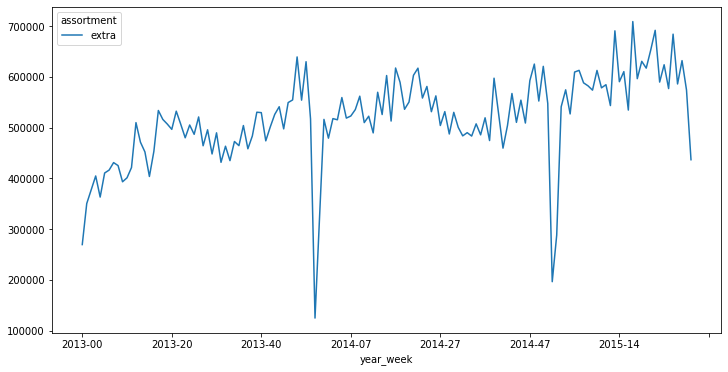

In [25]:
aux1 = df4[['sales', 'assortment']].groupby( 'assortment' ).sum().reset_index().sort_values( 'sales', ascending = False )
aux2 = df4[[ 'year_week', 'sales', 'assortment']].groupby( ['year_week' ,'assortment'] ).sum().reset_index().sort_values( 'sales', ascending = False )
aux3 = aux2[aux2['assortment'] == 'extra']

plt.figure( figsize = ( 12,6 ) )
sns.barplot( x= 'assortment', y = 'sales', data = aux1 );

aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot( figsize = ( 12,6 ) );

aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales' ).plot( figsize = ( 12,6 ) );

### 4.2.2. H2) Lojas com competidores mais próximos deveriam vender menos.
**Falsa.** Quanto maior a distancia dos competidores MENOR a venda.

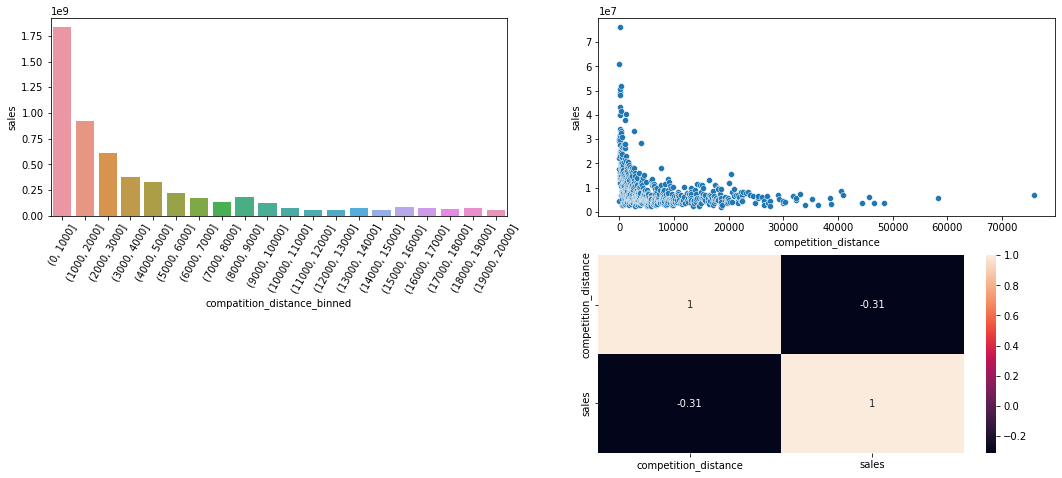

In [26]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = ( np.arange( 0, 21000, 1000 ) )

aux1['compatition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['compatition_distance_binned', 'sales']].groupby( 'compatition_distance_binned' ).sum().reset_index()

plt.figure( figsize = ( 18,8 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'compatition_distance_binned', y = 'sales', data = aux2 )
plt.xticks( rotation = 60 );

plt.subplot( 2, 2, 2 )
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 4 )
sns.heatmap( aux1.corr( method= 'pearson' ), annot= True);

### 4.2.3. H3) Lojas com competidores a mais tempo deveriam vender mais.
**Falsa.** Lojas com competidores a mais tempo vendem MENOS.

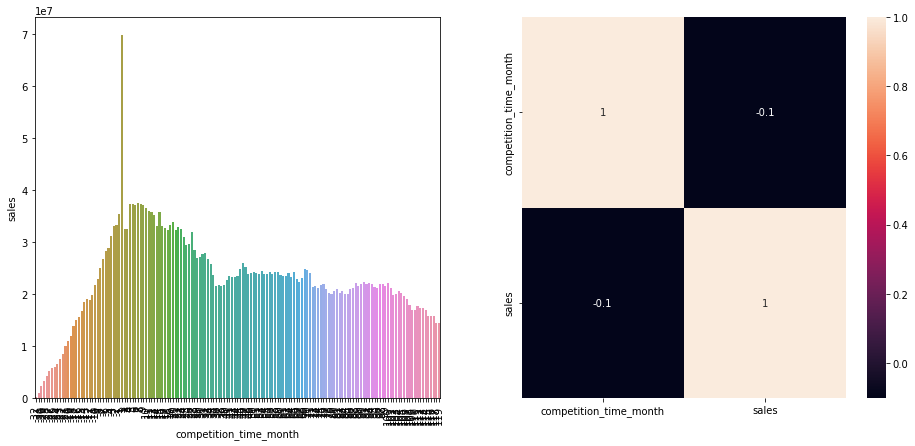

In [27]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 ) ]

plt.figure( figsize = ( 16, 7 ) )

plt.subplot( 1, 2, 1 )
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr(method = 'pearson'), annot= True  );

### 4.2.4. H4) Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa.** Lojas com promoção ativa por mais tempo vendem MENOS, depois de um determinado período. 

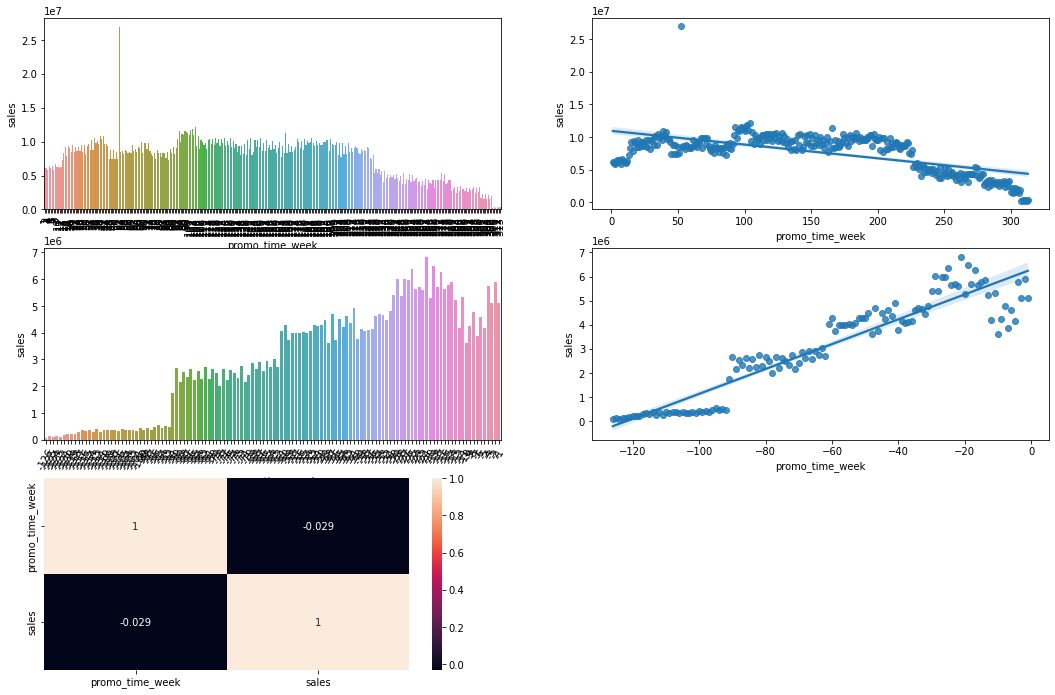

In [28]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

plt.figure( figsize = ( 18,12 ) )

plt.subplot( 3, 2, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2 )
plt.xticks( rotation = 90 );

plt.subplot( 3, 2, 2 )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2 );

plt.subplot( 3, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3 )
plt.xticks( rotation = 60 );

plt.subplot( 3, 2, 4 )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3 );

plt.subplot( 3, 2, 5 )
sns.heatmap( aux1.corr( method= 'pearson'), annot= True );

### <s> 4.2.5. H5) Lojas com mais dias de promoção deveriam vender mais. </s>


### 4.2.6. H6) Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa.** Lojas com mais promoções consecutivas vendem MENOS.

In [29]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


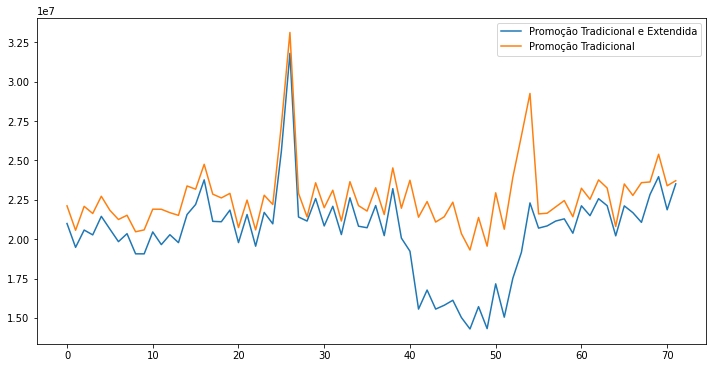

In [30]:
aux1 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax = ax, figsize = ( 12,6 ) )

plt.legend( ['Promoção Tradicional e Extendida', 'Promoção Tradicional' ] );

### 4.2.7. H7) Lojas abertas durante o feriado de Natal deveriam vender mais.
**Verdadeiro.** Lojas abertas durante o feriado de Natal vendem mais, em média.

In [31]:
aux2

,year_week,sales
0,2013-01,22118270
1,2013-03,20567037
2,2013-05,22087889
3,2013-07,21631750
4,2013-09,22727171
...,...,...
67,2015-22,23590590
68,2015-24,23635449
69,2015-26,25394352
70,2015-28,23393262


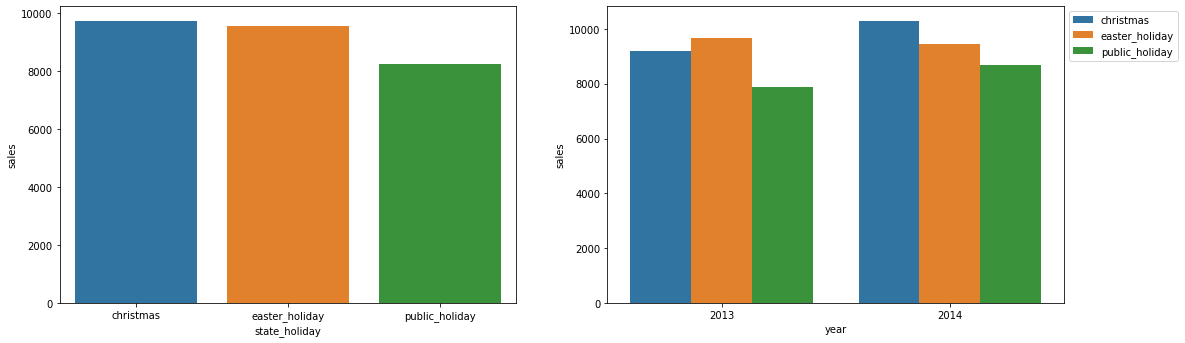

In [32]:
aux1 = df4[( df4['state_holiday'] != 'regular_day' ) & ( df4['year'] != 2015 )]
aux2 = aux1[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()

plt.figure( figsize = ( 18,12 ))
plt.subplot( 2, 2, 1 )
sns.barplot( x = 'state_holiday', y = 'sales', data = aux2 );

aux3 = aux1[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux3, )
plt.legend( loc='center left', bbox_to_anchor=(1, 0.9), ncol=1 );

### 4.2.8. H8) Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas Vendem MENOS ao longo dos anos.

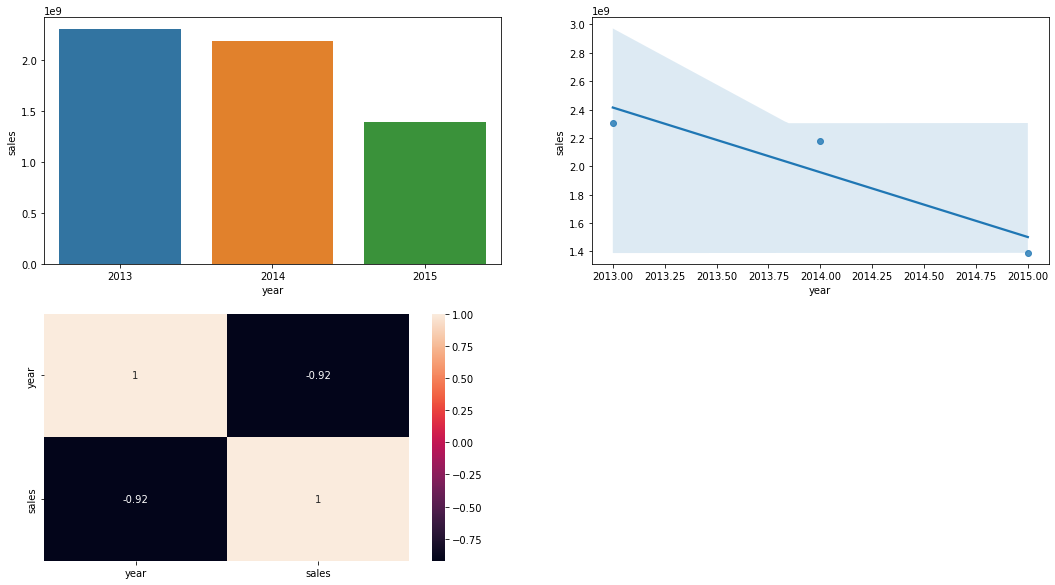

In [33]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.9. H9) Lojas deveriam vender mais durante o segundo semestre do ano.
**Verdadeiro.** Lojas vendem, em média, 4,62% a mais no segundo semestre.

In [34]:
aux = df4[df4['year'] != 2015 ]
aux1 = aux[['month', 'sales']].groupby( 'month' ).mean().reset_index()

bins = ( np.arange( 0, 13, 6 ) )
aux1['semester'] = pd.cut( aux1['month'], bins = bins )

aux1[['semester', 'sales']].groupby( 'semester' ).mean().reset_index()

,semester,sales
0,"(0, 6]",6771.293
1,"(6, 12]",7084.546


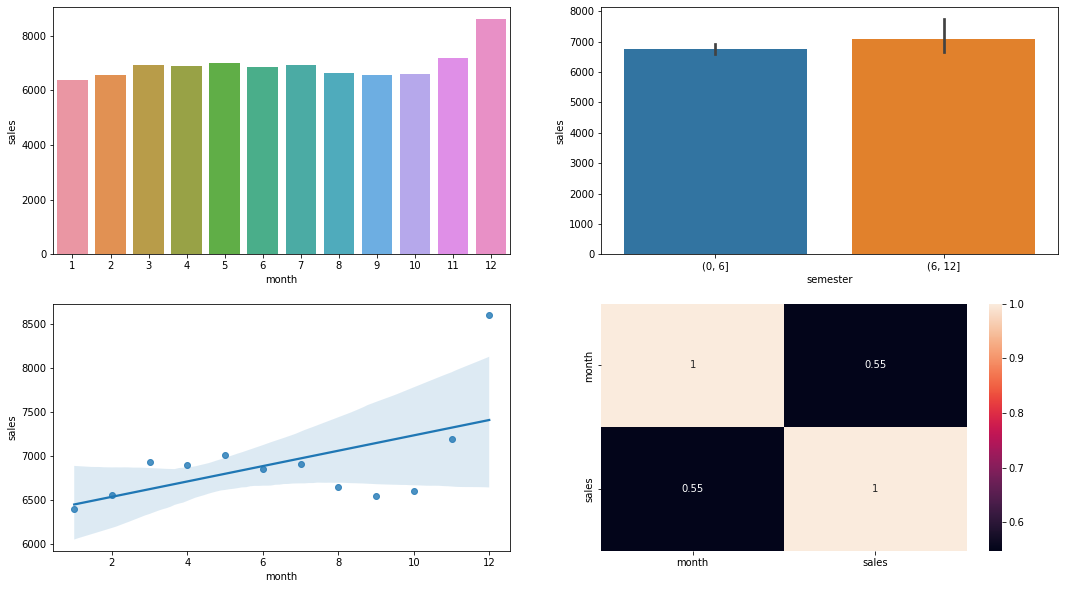

In [35]:
plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1)
sns.barplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2)
sns.barplot( x = 'semester', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 3)
sns.regplot( x = 'month', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 4)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.10 H10) Lojas deveriam vender mais antes do dia 10 de cada mês.
**Verdadeiro.** Em média, lojas vendem 7,08% a mais antes do 10 dia de cada mês. 

In [36]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).mean().reset_index()
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )

aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

aux2

,before_after,sales
0,after_10_days,6824.773
1,before_10_days,7307.763


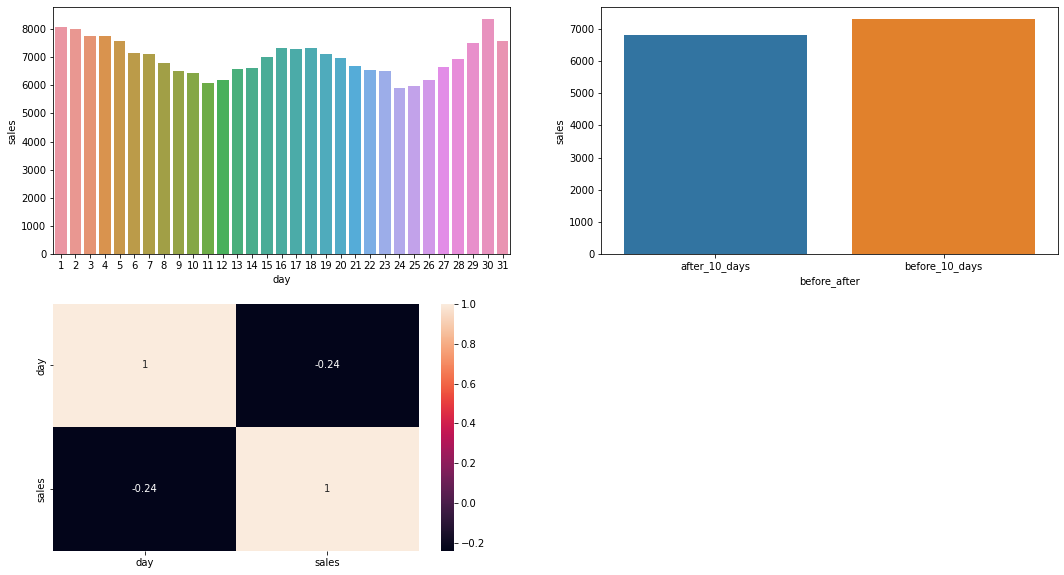

In [37]:
plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'day', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'before_after', y = 'sales', data = aux2 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.11. H11) Lojas deveriam vender menos durante os finais de semana.
**Verdadeiro.** Lojas vendem, em média, MENOS durante os finais de semana. 

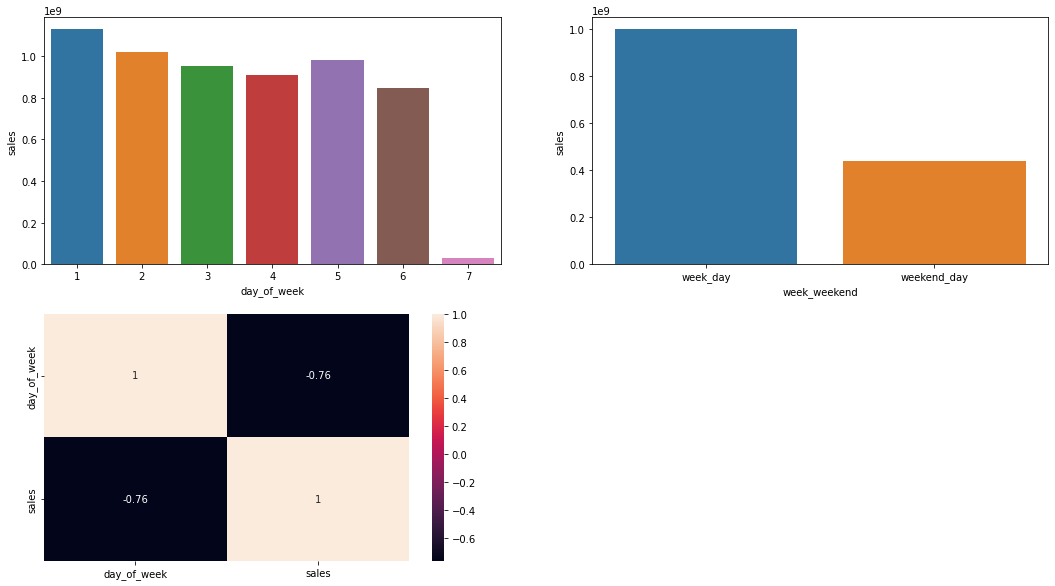

In [38]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
aux1['week_weekend'] = aux1['day_of_week'].apply( lambda x: 'week_day' if x <= 5 else 'weekend_day' )

aux2 = aux1[['week_weekend', 'sales']].groupby( 'week_weekend' ).mean().reset_index()

plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'week_weekend', y = 'sales', data = aux2 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.12. H12) Lojas deveriam vender menos nos feriados escolares
**Verdadeiro.** Lojas vendem menos nos feriados escolares, exceto no mes de Agosto.

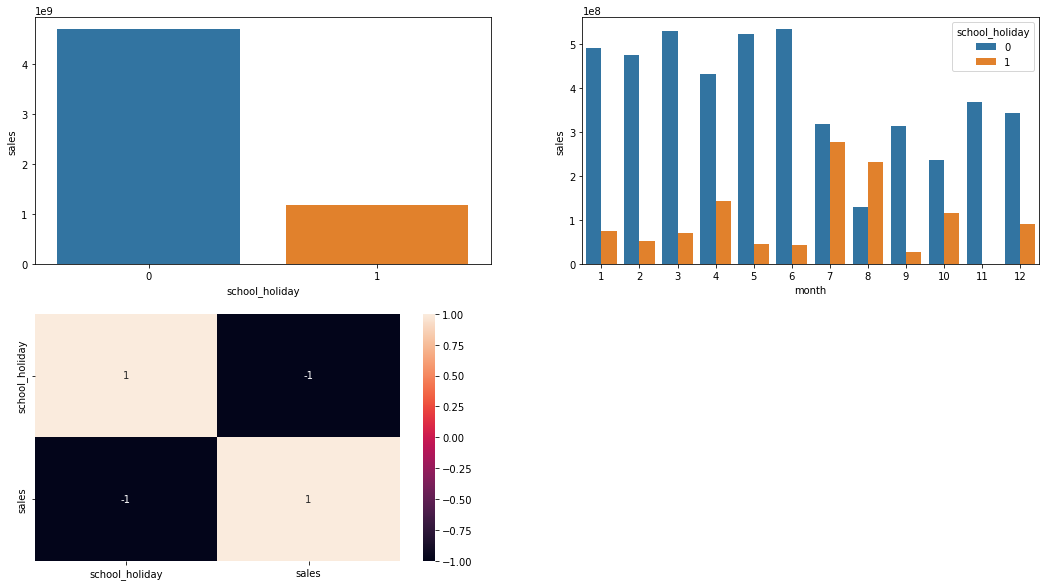

In [39]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

plt.figure( figsize = ( 18,10 ) )

plt.subplot( 2, 2, 1 )
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### 4.2.13. Resumo das hipoteseses

In [40]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falda', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Verdadeiro', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Verdadeiro', 'Alta'],
      ['H10', 'Verdadeiro', 'Media'],
      ['H11', 'Verdadeiro', 'ALta'],
      ['H12', 'Verdadeiro', 'Alta'],
      ]
print( tabulate( tab, headers= 'firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falda        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Verdadeiro   Media
H8           Falsa        Alta
H9           Verdadeiro   Alta
H10          Verdadeiro   Media
H11          Verdadeiro   ALta
H12          Verdadeiro   Alta


## 4.3. Analise Multivariada

### 4.3.1. Atributos Numericos 

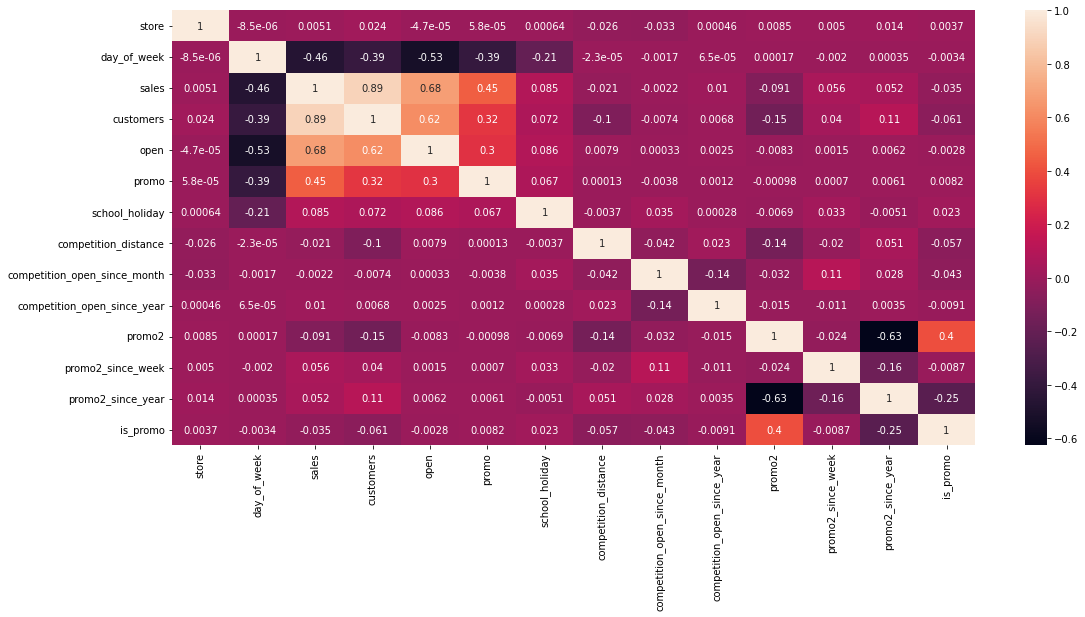

In [41]:
corralation = num_atributos.corr( method = 'pearson' )
plt.figure( figsize = ( 18,8 ) )
sns.heatmap( corralation, annot = True );

### 4.3.1. Atributos Categoricos

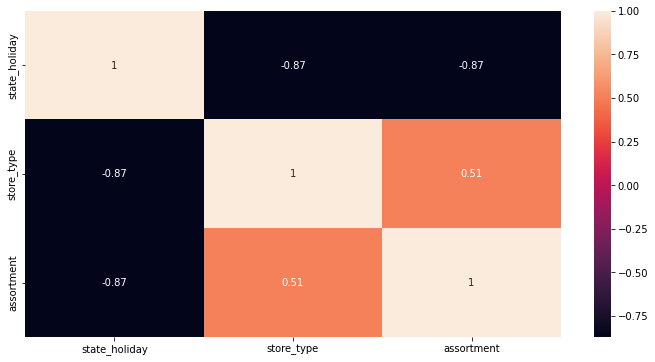

In [42]:
a = df4.select_dtypes( include= 'object' )

#calculo de cramer
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]} )

d = d.set_index( d.columns )

plt.figure( figsize= ( 12,6 ) )
sns.heatmap( d.corr(method = 'pearson'), annot = True );

# 5.0. Modelagem dos Dados

In [43]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [44]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3. Transformacao

### 5.3.1. Encoding

In [45]:
# state_holiday - OneHotEncoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns = ['state_holiday'] )

# store_type - LabelEcoder
encoder = LabelEncoder()
df5['store_type'] = encoder.fit_transform( df5['store_type'] )

# assortment - Ordinal Econding
assortment_dict = { 'basic': 1, 'extra': 2, 'extended': 3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Transformacao Variavel Reposta

In [46]:
# transformacao logaratmica
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Transformacao de Natureza Ciclica

In [47]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )

# 6.0. Selecao de Variaveis

In [48]:
df6 = df5.copy()

## 6.1. Split do DataFrame para treino e teste

In [49]:
# drop das colunas que foram derivadas
cols_drop = ['day_of_week', 'week_of_year', 'day', 'month',
             'promo_since', 'competition_since', 'year_week']

df6 = df6.drop( cols_drop, axis = 1 )

In [50]:
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - timedelta( days = 7 * 6 )

Timestamp('2015-06-19 00:00:00')

In [51]:
# dados de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# dados de teste
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Train Min date {}'.format( X_train['date'].min() ) )
print( 'Train Max date {}'.format( X_train['date'].max() ) )

print( '\nTest Min date {}'.format( x_test['date'].min() ) )
print( 'Test Max date {}'.format( x_test['date'].max() ) ) 

Train Min date 2013-01-01 00:00:00
Train Max date 2015-06-18 00:00:00

Test Min date 2015-06-19 00:00:00
Test Max date 2015-07-31 00:00:00


## 6.2. Boruta como Seletor de Variaveis

In [52]:
# treino e test para o boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis = 1 ).values
# Y_train_n = Y_train.values

# definir Random Forest
# rf = RandomForestRegressor( n_jobs= -1 )

# dfinicao boruta
# boruta = BorutaPy( rf, n_estimators= 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, Y_train_n )

### 6.2.1. Melhores Variaveis do Boruta

In [53]:
# cols_selected = boruta.support_.tolist()

## melhores variaveis
# X_train_mv = X_train.drop( ['date', 'sales'], axis = 1 )
# cols_selected_boruta =  X_train_mv.iloc[:, cols_selected].columns.to_list()

## 6.3. Selecao Manual de Variaveis

In [54]:
cols_selected_boruta = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'month_cos',
                         'month_sin',
                         'day_sin',
                         'day_cos',
                         'week_of_year_cos',
                         'week_of_year_sin',
                         'day_of_week_sin',
                         'day_of_week_cos']

# variaveis para adicionar
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. Modelos de Machine Learning

In [55]:
# dados de treino e test
x_train = X_train[cols_selected_boruta]
X_test = x_test[ cols_selected_boruta]

# preparacao dos para time series
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [56]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'prediction'} )
aux1 = pd.merge( aux1, aux2, how = 'left', on = 'store' )
yhat_baseline = aux1['prediction']

# perform
baseline_result = ml_error( 'Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800,0.455,1835.136


## 7.2. Linear Regressor Model

In [57]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.834,0.294,2672.314


### 7.2.1. Linear Regressor Model - Cross Validation

In [58]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2084.03 +/- 295.65,0.3 +/- 0.02,2950.2 +/- 468.48


## 7.3. Linear Regressor Lasso Model

In [59]:
# model
lrl = Lasso( alpha = 0.01 ).fit( x_train, y_train )

# prediction
yhat_lrl = lrl.predict( X_test )

# performance
lrl_result = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrl ) )
lrl_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1894.274,0.289,2745.426


### 7.3.1. Linear Regressor Lasso Model - Cross Validation


In [60]:
lrl_result_cv = cross_validation( x_training, 5, 'Lasso', lrl )
lrl_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.78 +/- 341.3,0.29 +/- 0.01,3057.53 +/- 503.93


## 7.4. Random Forest Model

In [60]:
# model
rn = RandomForestRegressor( n_estimators = 100, n_jobs = -1,  random_state = 42 ).fit( x_train, y_train )

# prediction
yhat_rn = rn.predict( X_test )

# performance
rn_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rn ) )
rn_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,660.087,0.097,983.434


### 7.4.1. Random Forest Model - Cross Validation

In [127]:
rn_result_cv = cross_validation( x_training, 5, 'Random Forest', rn )
rn_result_cv


 Kfolde Number 5

 Kfolde Number 4

 Kfolde Number 3

 Kfolde Number 2

 Kfolde Number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,833.68 +/- 216.09,0.12 +/- 0.02,1248.73 +/- 315.13


## 7.5. XGBoost Regressor Model

In [61]:
# model
xgb_model = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = 100).fit( x_train, y_train )

# prediction
yhat_xgb = xgb_model.predict( X_test )

xgb_result = ml_error( 'XGBoost Regressor Model', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Model,894.616,0.133,1297.327


### 7.5.1. XGBoost Model - Cross Validation

In [62]:
xgb_model_result_cv = cross_validation( x_training, 5, 'XGBoost', xgb_model )
xgb_model_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1071.22 +/- 140.94,0.15 +/- 0.01,1530.69 +/- 191.5


## 7.6. Comparacao da Performance dos Modelos

### 7.6.1. Performance dos modelos

In [62]:
models_result =  pd.concat( [baseline_result, lr_result, lrl_result, rn_result, xgb_result ] )
models_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,660.087,0.097,983.434
0,XGBoost Regressor Model,894.616,0.133,1297.327
0,Avarage Model,1354.800,0.455,1835.136
0,Linear Regression,1872.834,0.294,2672.314
0,Linear Regression Lasso,1874.737,0.289,2694.942


### 7.6.2. Performance dos modelos - Cross Valida

In [132]:
models_result_cv = pd.concat( [lr_result_cv, lrl_result_cv, rn_result_cv, xgb_model_result_cv] )
models_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,833.68 +/- 216.09,0.12 +/- 0.02,1248.73 +/- 315.13
0,XGBoost,1071.22 +/- 140.94,0.15 +/- 0.01,1530.69 +/- 191.5
0,Linear Regression,2084.03 +/- 295.65,0.3 +/- 0.02,2950.2 +/- 468.48
0,Lasso,2117.78 +/- 341.3,0.29 +/- 0.01,3057.53 +/- 503.93


# 8.0. Hyperparameter Fine Tunning

## 8.1. Random Search

In [89]:
params = {'n_estimators': [100, 170, 250, 300, 450],
        'eta': [0.01, 0.3],
        'max_depth': [3, 5, 9],
        'min_child_weight': [3, 8, 15] }

max_eval = 10

In [91]:
final_result = pd.DataFrame()

for i in range ( max_eval ):
    # escolher o valor dos parametros aleatoriamente
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print( hp )
    
    # model
    xgb_model_tunned = xgb.XGBRegressor( objective = 'reg:squarederror',
                                  n_estimators = hp[ 'n_estimators'],
                                  eta =  hp['eta'],
                                  max_depth = hp['max_depth'],
                                  min_child_weight = hp['min_child_weight'])


    result = cross_validation( x_training, 2, 'XGBoost Regressor', xgb_model_tunned )
    final_result = pd.concat( [final_result, result] )
    
final_result

{'n_estimators': 170, 'eta': 0.3, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 300, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 100, 'eta': 0.3, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 170, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 450, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 250, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 100, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 100, 'eta': 0.3, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 250, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1,

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1460.68 +/- 64.08,0.2 +/- 0.0,2119.08 +/- 118.91
0,XGBoost Regressor,951.56 +/- 99.62,0.13 +/- 0.01,1366.69 +/- 171.15
0,XGBoost Regressor,894.65 +/- 87.03,0.12 +/- 0.01,1282.77 +/- 153.34
0,XGBoost Regressor,1032.66 +/- 80.49,0.14 +/- 0.01,1494.7 +/- 149.21
0,XGBoost Regressor,2139.95 +/- 56.78,0.27 +/- 0.0,3115.92 +/- 103.6
0,XGBoost Regressor,4053.78 +/- 70.92,0.5 +/- 0.0,4861.86 +/- 125.42
0,XGBoost Regressor,1188.75 +/- 53.95,0.16 +/- 0.0,1731.09 +/- 120.27
0,XGBoost Regressor,1180.58 +/- 45.97,0.16 +/- 0.0,1720.51 +/- 109.73
0,XGBoost Regressor,4110.38 +/- 72.99,0.5 +/- 0.0,4999.03 +/- 125.22
0,XGBoost Regressor,1617.78 +/- 66.25,0.22 +/- 0.0,2347.45 +/- 120.33


## 8.2. Final Model

In [61]:
param_tunned = {'n_estimators': 100,
                'eta': 0.3,
                'max_depth': 9,
                'colsample_bytree': 0.9,
                'min_child_weight': 8 }

In [62]:
# model
xgb_model_tunned = xgb.XGBRegressor( objective = 'reg:squarederror',
                                     n_estimators = param_tunned[ 'n_estimators'],
                                     eta =  param_tunned['eta'],
                                     max_depth = param_tunned['max_depth'],
                                     colsample_bytree = param_tunned['colsample_bytree'],
                                     min_child_weight = param_tunned['min_child_weight']).fit( x_train, y_train )

# predict
yhat_tunned = xgb_model_tunned.predict( X_test )

# performance
result_tunned = ml_error( 'XGBoost Regressor Tunned', np.expm1( y_test ), np.expm1( yhat_tunned ) )
result_tunned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tunned,728.030,0.106,1058.960


In [63]:
# erro médio percentual do modelo
mean_percentage_error(np.expm1(y_test), np.expm1(yhat_tunned))

-0.004360695277310512

In [73]:
# save do modelo pronto
pickle.dump( xgb_model_tunned, open( 'C:/Users/Criso/repos/rossmann_project/model/model_rossmann.pkl', 'wb' ) )

# 9.0. Traducao e Interpretacao do Erro

In [64]:
df9 = x_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_tunned )

## 9.1. Performance de Negócio

In [65]:
# soma das predições por loja
aux1 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0: 'MAE'} )
aux3 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0: 'MAPE'} )

aux4 = pd.merge( aux2, aux3, how = 'inner', on = 'store' )
aux5 = pd.merge( aux1, aux4, how = 'inner', on = 'store' )

# cenários
aux5['worst_scenario'] = aux5['predictions'] - aux5['MAE']
aux5['best_scenario'] = aux5['predictions'] + aux5['MAE']

# ordenamento das colunas
aux5 = aux5[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
aux5.head(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162758.766,162477.090,163040.441,281.675,0.066
1,2,175885.969,175512.993,176258.944,372.976,0.075
2,3,262982.469,262360.144,263604.793,622.325,0.085
3,4,342832.688,341930.652,343734.723,902.035,0.087
4,5,179768.969,179290.917,180247.020,478.051,0.110


<AxesSubplot:xlabel='store', ylabel='MAPE'>

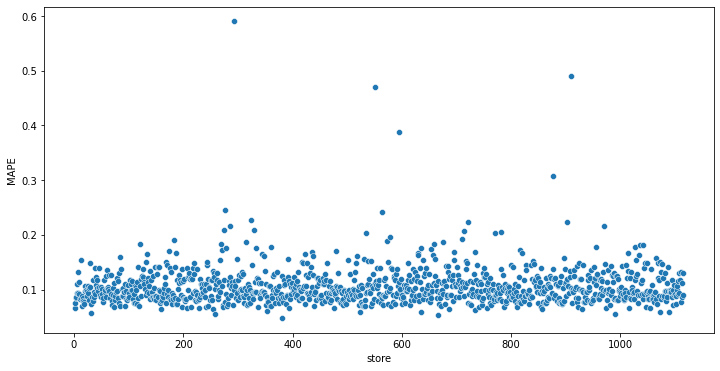

In [68]:
plt.figure( figsize = ( 12,6 ) )
sns.scatterplot( x = 'store', y = 'MAPE', data = aux5 )

## 9.1. Performance Total

In [79]:
aux6 = aux5[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis = 0 ).reset_index().rename( columns = { 'index': 'scenarios', 0: 'total_revenue' } )
aux6['total_revenue'] = aux6['total_revenue'].map( 'U$ {:,.2f}'.format )
aux6

,scenarios,total_revenue
0,predictions,"U$ 284,718,848.00"
1,worst_scenario,"U$ 283,903,549.93"
2,best_scenario,"U$ 285,534,108.54"


## 9.1. Performance Machine Learning

In [80]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

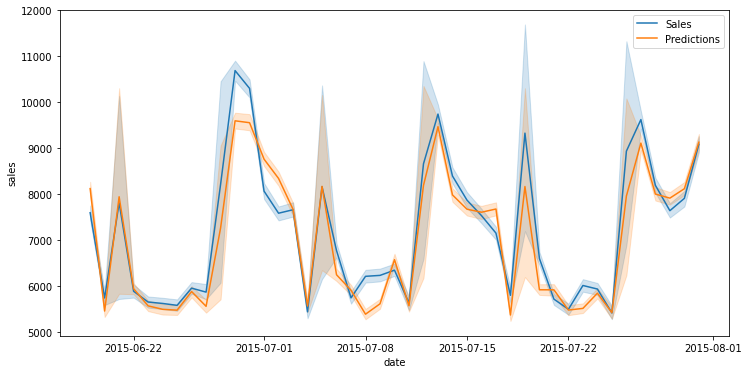

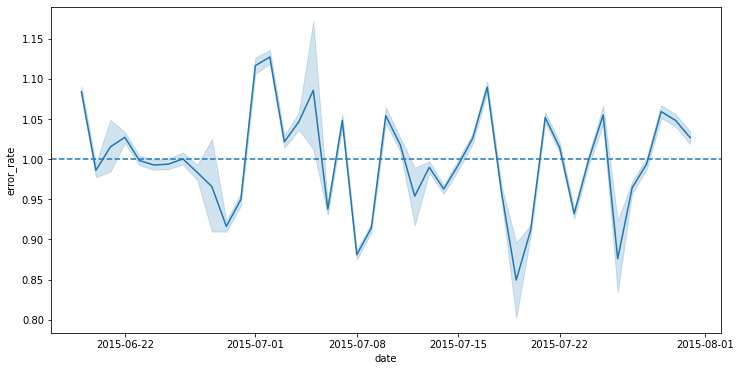

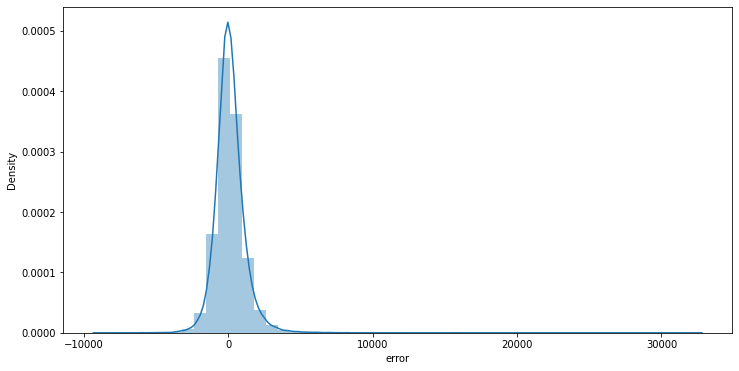

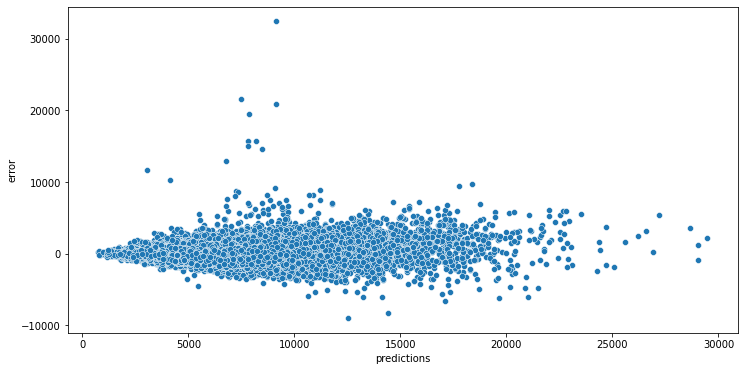

In [89]:
plt.figure( figsize = ( 12 , 6 ) )
sns.lineplot( x = 'date', y = 'sales', data= df9, label = 'Sales' )
sns.lineplot( x = 'date', y = 'predictions', data= df9, label = 'Predictions' );

plt.figure( figsize = ( 12 , 6 ) )
sns.lineplot( x = 'date', y = 'error_rate', data= df9)
plt.axhline( 1, linestyle = '--' );

plt.figure( figsize = ( 12 , 6 ) )
sns.distplot( df9['error']);

plt.figure( figsize = ( 12 , 6 ) )
sns.scatterplot( x = 'predictions', y = 'error', data= df9);
